Imports

In [1]:
# Standard Library
import os

# Data Processing Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# SentencePiece
import sentencepiece as spm

# Word2Vec
from gensim.models import Word2Vec

# Model Evaluation
from sklearn.model_selection import train_test_split

# Model Creation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

Check device is set to GPU

In [2]:
if os.sys.platform == 'darwin':      # MacOS
    device = torch.device("mps" if torch.cuda.is_available() else "cpu")
elif os.sys.platform == 'win32':    # Windows
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:                               # other OS
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


Load Dataset

In [3]:
file_path = './data/TitlesAndScoreALL.csv'
data_df = pd.read_csv(file_path, sep=',')

In [4]:
data_df['title'] = data_df['title'].str.lower()

In [5]:
def dataframe_sentence_generator(df):
    for sentence in df:
        yield sentence
        
spm.SentencePieceTrainer.train(
    sentence_iterator=dataframe_sentence_generator(data_df['title']), 
    vocab_size=12_828,
    model_prefix='./data/spm_model', 
    model_type='unigram',
)

sp = spm.SentencePieceProcessor()

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: ./data/spm_model
  model_type: UNIGRAM
  vocab_size: 12828
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0
  different

Load the SentencePiece model

In [6]:
sp.load('./data/spm_model.model')

True

Tokenizer

In [7]:
def get_sentence_tokens(sentence):
    '''Gets the word tokens of a given sentence by tokenising'''
    tokens = sp.encode_as_pieces(sentence)
    return tokens

def get_avg_vector_for_sent(tokens, model):
    '''Uses the Word2Vec LUT to get the vector representation of a tokens 
       in a sentence and takes the mean'''
    vector = np.zeros(model.vector_size)
    for token in tokens:
        if token in model.wv:
            vector += model.wv[token]
    if len(tokens) > 0: 
        vector /= len(tokens)
    return vector
    
def sentence_to_vector(sentence, model):
    '''Returns the vector representation of a sentence
       by taking the average of the Word2Vec representations of the 
       words / subwords'''
    tokens = get_sentence_tokens(sentence)
    vector = get_avg_vector_for_sent(tokens, model)
    return vector


In [8]:
word_dimensionality = 500

In [9]:
# class Word2Vec: # TODO: Define custom Word2Vec class
#     def __init__(sentences=tokens_list, vector_size=word_dimensionality, window=5, min_count=1, workers=4):
#         pass

In [10]:
tokenized_titles = [sp.encode_as_pieces(title) for title in data_df['title']]
word2vec_model = Word2Vec(sentences=tokenized_titles, vector_size=word_dimensionality, window=5, min_count=1, workers=4)
data_df['sentence_vector'] = data_df['title'].apply(lambda x: sentence_to_vector(x, word2vec_model))

In [11]:
data_df.head()

,id,title,score,sentence_vector
0,442106,"for peruvians, baskets for the u.s. market bri...",1,"[0.012462249557886804, 0.07224805528918903, -0..."
1,442112,wsj.com : president obama's inaugural address,1,"[0.04569271830841899, 0.017771509662270545, 0...."
2,551087,smart way to share psd files using diff and patch,1,"[-0.04785990957170725, -0.006058910489082336, ..."
3,551119,download yahoo messenger for iphone,1,"[-0.09570676609873771, 0.09085485115647315, 0...."
4,551165,reinventing the conference call,1,"[0.17151999920606614, 0.27743336409330366, 0.1..."


Train Test Split

In [12]:
# Split the data into training and test sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(
    data_df['sentence_vector'].tolist(), 
    data_df['score'], 
    test_size=0.3, 
    random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_and_val, 
    y_test_and_val, 
    test_size=0.5, 
    random_state=42
)

In [13]:
X_train = torch.tensor(np.vstack(X_train), dtype=torch.float)
y_train = torch.tensor(np.array(y_train), dtype=torch.float).view(-1, 1)

X_test = torch.tensor(np.vstack(X_test), dtype=torch.float)
y_test = torch.tensor(np.array(y_test), dtype=torch.float) .view(-1, 1)

X_val = torch.tensor(np.vstack(X_val), dtype=torch.float)
y_val = torch.tensor(np.array(y_val), dtype=torch.float) .view(-1, 1)

Model

In [14]:
class UpvotesPredictorNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(UpvotesPredictorNN, self).__init__()
        
        # Input layer to 1st hidden layer
        self.fc1 = nn.Linear(word_dimensionality, 64)
        self.relu1 = nn.ReLU()
        
        # 1st hidden layer to 2nd hidden layer
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        
        # 2nd hidden layer to output layer
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        output = self.output(x)
        return output

In [15]:
# Define model and hyperparameters
model = UpvotesPredictorNN()
criterion = nn.MSELoss()
num_epochs = 500
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Batching
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)



# Storage object for data vis
list_of_lists = []

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    for batch_idx, (data,target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
    
    # Set model to evaluation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            val_out = model(X_val)
            val_loss = criterion(val_out, y_val)
    
    # Store loss for data vis
    list_of_lists.append([epoch, loss.item(), val_loss.item()])
    
    # Logging
    print(f'Epoch {epoch+1},\t Train Loss: {loss.item()},\t Val Loss: {val_loss.item()}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x32 and 64x1)

In [ ]:
train_loss_list = []
val_loss_list = []
epoch_list = []

for i,j,k in list_of_lists:
    epoch_list.append(i)
    train_loss_list.append(j)
    val_loss_list.append(k)

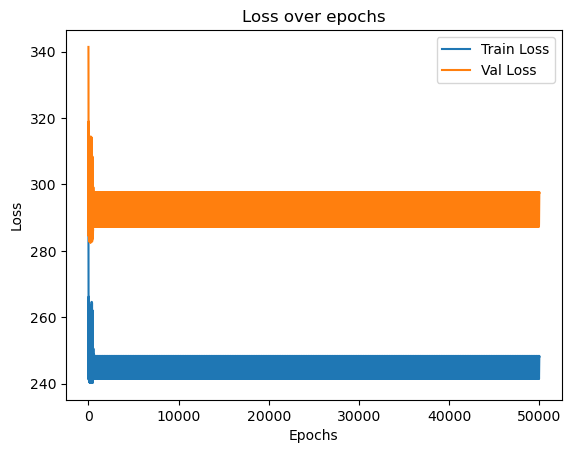

In [ ]:
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, val_loss_list, label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    model.eval()
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test) 

print(f'Test Loss: {test_loss.item()}')

Test Loss: 314.4490661621094


In [ ]:
index_to_check = 0

with torch.no_grad():
    model.eval()
    predictions = model(X_test)

specific_test_example = X_test[index_to_check]
predicted_value = predictions[index_to_check]
actual_value = y_test[index_to_check]

print("Original Sentence:", data_df['title'].iloc[index_to_check])
print("Predicted Upvotes Value:", predicted_value.item())
print("Actual Upvotes Value:", actual_value.item())

Original Sentence: In A Down Economy, Startups Rise From Coworking 
Predicted Upvotes Value: 4.308069705963135
Actual Upvotes Value: 1.0


EDA

In [ ]:
print(data_df['score'].describe())


count    10000.000000
mean         7.160100
std         16.039707
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        242.000000
Name: score, dtype: float64


/Users/jacob/miniconda3/envs/mlx4-2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


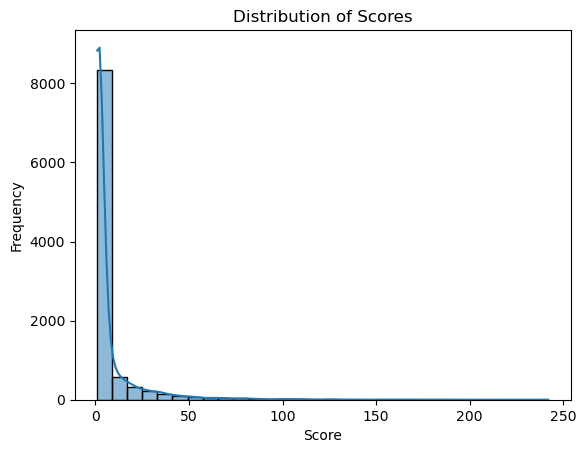

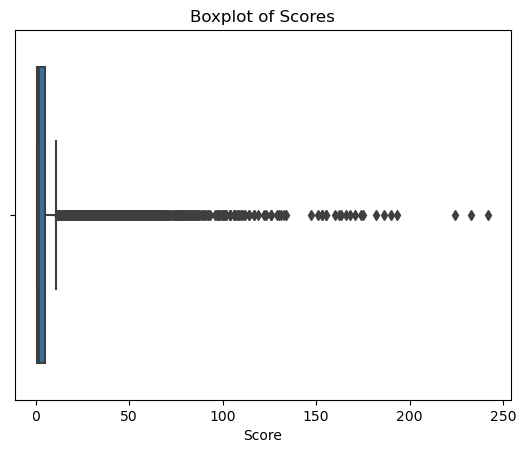

In [ ]:

# Histogram of scores
sns.histplot(data_df['score'], bins=30, kde=True)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Boxplot for outlier visualization
sns.boxplot(x=data_df['score'])
plt.title('Boxplot of Scores')
plt.xlabel('Score')
plt.show()


In [ ]:
print("Skewness: %f" % data_df['score'].skew())
print("Kurtosis: %f" % data_df['score'].kurt())


Skewness: 5.346292
Kurtosis: 41.037711


/Users/jacob/miniconda3/envs/mlx4-2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


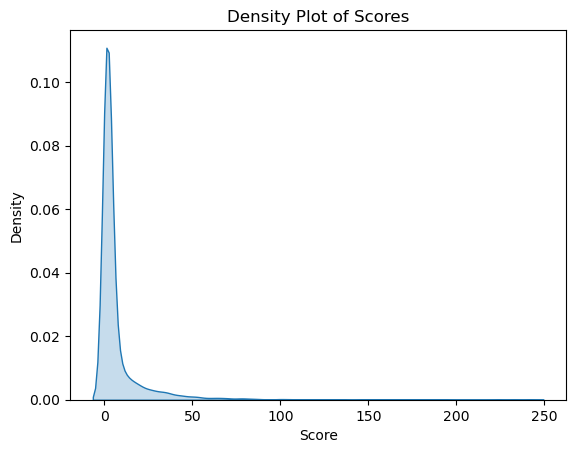

In [ ]:
sns.kdeplot(data_df['score'], fill=True)
plt.title('Density Plot of Scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()
